In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# ==============================
# 1. Carregar e preparar os dados
# ==============================
df = pd.read_csv("Data/AccountInteractions.csv").sort_values("AccountId")
df['OrderClassification'] = df['OrderClassification'].fillna(0).astype(int)

In [2]:
df['ProductLine'] = df['ProductLine'].astype('category')
df['Size'] = df['Size'].astype('category')

In [3]:
y = df["OrderClassification"]

feature_cols = [
    'NetValue', 
    'Quantity',
    'Recency', 
    'CartRecency',
    'Weight', 
    'ProductLine', 
    'Size', 
    'TotalPrice3Month',
    'TotalPrice6Month', 
    'TotalQuantity3Month', 
    'TotalQuantity6Month',
    'CountOrder3Month', 
    'CountOrder6Month', 
    'OrderQuantity', 
    'CartQuantity', 
    'TotalPriceCart3Month',
    'TotalPriceCart6Month', 
    'TotalQuantityCart3Month',
    'TotalQuantityCart6Month', 
    'CountCart3Month', 
    'CountCart6Month',
    'CartNetValue', 
    'OrderNetValue', 
    'CountOrder', 
    'CountCart',
    'AverageOrderTicket', 
    'AverageOrderTicket3Month',
    'AverageOrderTicket6Month', 
    'AverageCartTicket',
    'AverageCartTicket3Month', 
    'AverageCartTicket6Month',
    'ProductPopularity', 
    'TotalPriceByAccount', 
    'TotalQuantityByAccount',
    'RelativePriceProduct', 
    'RelativePriceAccount'
]

X = df[feature_cols]

In [4]:
# ==============================
# 2. Split por AccountId (sem vazar info)
# ==============================
unique_accounts = df["AccountId"].unique()
train_ids, test_ids = train_test_split(unique_accounts, test_size=0.2, random_state=42)

train_df = df[df["AccountId"].isin(train_ids)]
test_df  = df[df["AccountId"].isin(test_ids)]

X_train, y_train = train_df[feature_cols], train_df["OrderClassification"].astype(int)
X_test, y_test   = test_df[feature_cols],  test_df["OrderClassification"].astype(int)

# Grupos por conta (cada cliente é um grupo de produtos)
train_groups = train_df.groupby("AccountId").size().to_list()
test_groups  = test_df.groupby("AccountId").size().to_list()

train_data = lgb.Dataset(X_train, label=y_train, group=train_groups)
test_data  = lgb.Dataset(X_test, label=y_test, group=test_groups, reference=train_data)

In [5]:
# ==============================
# 3. Hiperparâmetros otimizados
# ==============================
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5, 10],   # Avaliação no top-5 e top-10
    "learning_rate": 0.01,
    "num_leaves": 1024,
    #"min_data_in_leaf": 20, #Valor Mínimo de dados por folha, para evitar overfitting
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    # 'early_stopping_rounds':1000
}

In [6]:
# ==============================
# 4. Treinamento
# ==============================
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["train", "valid"],
    num_boost_round=2000,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5637
[LightGBM] [Info] Number of data points in the train set: 89342, number of used features: 36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [7]:
scores = model.predict(df[feature_cols])
product_ids = df['ProductCode'].to_list()
ranking = sorted(zip(product_ids, scores), key=lambda x: x[1], reverse=True)

print(f"\nRanking de produtos recomendados para Account:")
for prod, score in ranking:
    print(f"Produto {prod} - score {score:.4f}")


Ranking de produtos recomendados para Account:
Produto 58029000 - score 9.2096
Produto 78502750 - score 9.1474
Produto 57106004 - score 8.7959
Produto 78506750 - score 8.7195
Produto 41128107 - score 8.3998
Produto 57304002 - score 8.3610
Produto 61227120 - score 8.3459
Produto 57106007 - score 8.3375
Produto 41450006 - score 8.2314
Produto 94520036 - score 8.2148
Produto 25850160 - score 8.1681
Produto 78304511 - score 8.1541
Produto 41450007 - score 8.1164
Produto 23498028 - score 8.0754
Produto 58015143 - score 8.0409
Produto 41052112 - score 8.0054
Produto 41128106 - score 7.9858
Produto 78514750 - score 7.9857
Produto 42805114 - score 7.9829
Produto 77396085 - score 7.9370
Produto 78102801 - score 7.9135
Produto 42620059 - score 7.9129
Produto 57304003 - score 7.8412
Produto 41128126 - score 7.7979
Produto 42805112 - score 7.7752
Produto 57500005 - score 7.7572
Produto 41128108 - score 7.7529
Produto 57106003 - score 7.7487
Produto 61636103 - score 7.7445
Produto 43199002 - score

In [8]:
# ==============================
# 5. Predição e Ranking em um cliente específico
# ==============================
account_id = '0018c00002uQ4MFAA0'

X_new = df[df['AccountId'] == account_id][feature_cols]
product_ids = df[df['AccountId'] == account_id]['ProductCode'].to_list()

scores = model.predict(X_new)

ranking = sorted(zip(product_ids, scores), key=lambda x: x[1], reverse=True)

print(f"\nRanking de produtos recomendados para Account {account_id}:")
for prod, score in ranking:
    print(f"Produto {prod} - score {score:.4f}")


Ranking de produtos recomendados para Account 0018c00002uQ4MFAA0:
Produto 79210521 - score 7.1354
Produto 79170520 - score 6.6573
Produto 78508750 - score 6.1314
Produto 79246523 - score 5.3825
Produto 78506750 - score 5.0727
Produto 78502750 - score 4.9982
Produto 78514750 - score 4.5829
Produto 77480504 - score 4.0110
Produto 77850721 - score 3.9092
Produto 77540425 - score 3.5839
Produto 43800007 - score -2.9888
Produto 78519500 - score -3.0458
Produto 42383216 - score -3.0528
Produto 77571803 - score -3.1111
Produto 77270754 - score -3.2324
Produto 78592000 - score -3.2847
Produto 23498449 - score -3.3272
Produto 94538712 - score -3.7502
Produto 77214654 - score -3.7586
Produto 43800004 - score -3.9068
Produto 66906890 - score -3.9252
Produto 61636107 - score -4.0121
Produto 77215754 - score -4.2390
Produto 78382001 - score -4.2740
Produto 77459544 - score -4.2949
Produto 24038000 - score -4.3563
Produto 43800005 - score -4.4811
Produto 94020107 - score -4.5755
Produto 77400524 - 

In [9]:
# =========================================================
# 6. Avaliação completa no conjunto de teste
# =========================================================
from sklearn.metrics import ndcg_score

# Fazer predições para todo o conjunto de teste
test_predictions = model.predict(X_test)

# Adicionar as predições de volta ao dataframe de teste para facilitar o agrupamento
test_df['predictions'] = test_predictions

# Lista para armazenar o NDCG de cada grupo (cliente)
ndcg_scores_k5 = []
ndcg_scores_k10 = []

# Iterar sobre cada cliente no conjunto de teste
for account_id in test_df['AccountId'].unique():
    # Filtrar os dados do cliente atual
    client_data = test_df[test_df['AccountId'] == account_id]
    
    # Pegar os scores de relevância verdadeiros e os previstos
    true_relevance = client_data['OrderClassification'].values.reshape(1, -1)
    predicted_scores = client_data['predictions'].values.reshape(1, -1)
    
    # Ignorar clientes com apenas itens irrelevantes (NDCG é indefinido)
    if np.sum(true_relevance) > 0:
        # Calcular NDCG @ 5 e @ 10
        ndcg_k5 = ndcg_score(true_relevance, predicted_scores, k=5)
        ndcg_k10 = ndcg_score(true_relevance, predicted_scores, k=10)
        
        ndcg_scores_k5.append(ndcg_k5)
        ndcg_scores_k10.append(ndcg_k10)

# Calcular a média final do NDCG
mean_ndcg_k5 = np.mean(ndcg_scores_k5)
mean_ndcg_k10 = np.mean(ndcg_scores_k10)

print("\n========================================")
print("Avaliação Final no Conjunto de Teste")
print(f"NDCG médio @ 5: {mean_ndcg_k5:.4f}")
print(f"NDCG médio @ 10: {mean_ndcg_k10:.4f}")
print("========================================")

/tmp/ipykernel_30431/2742501935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predictions'] = test_predictions



Avaliação Final no Conjunto de Teste
NDCG médio @ 5: 0.9250
NDCG médio @ 10: 0.9319


/home/vitor/Documents/Unisinos/TCC/TCC_VITOR_H_SPADER/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


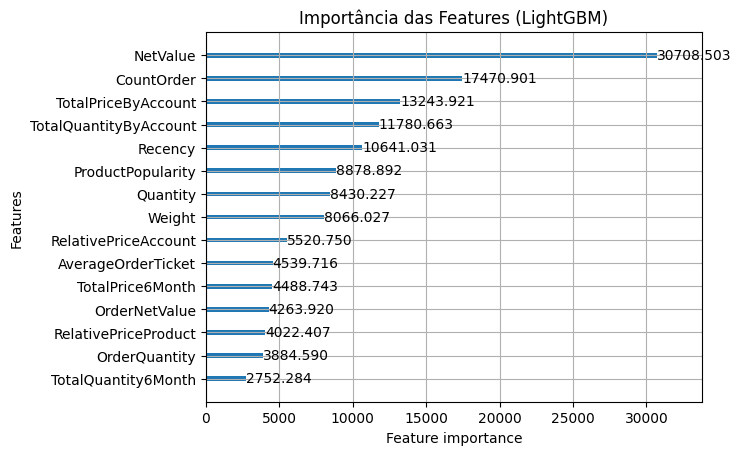

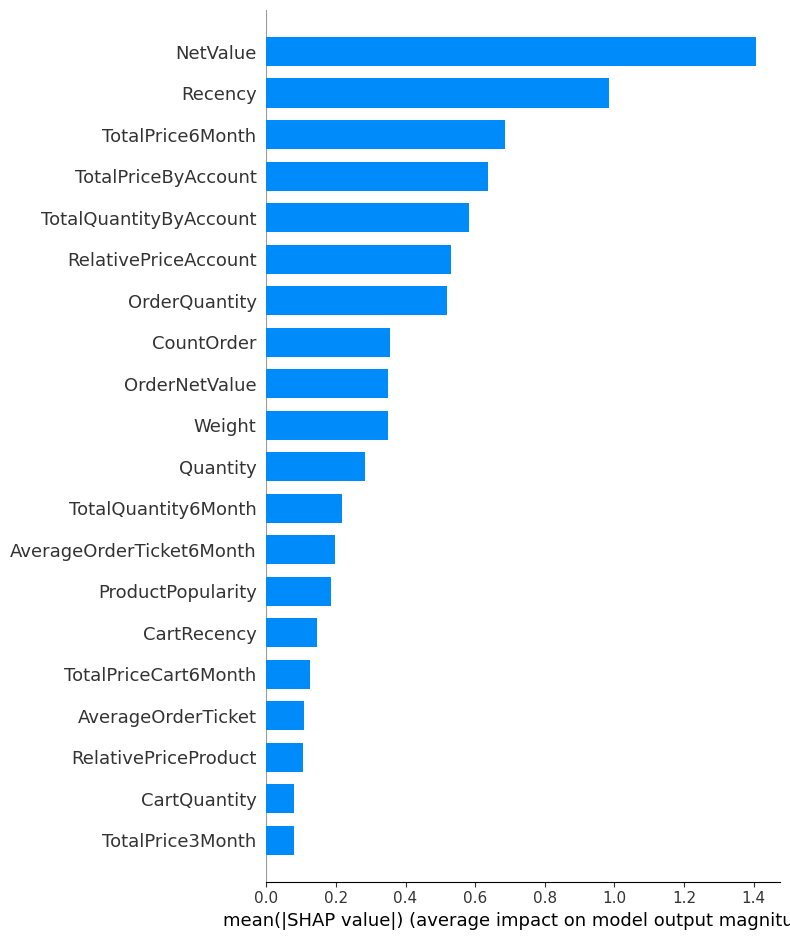

In [10]:
import matplotlib.pyplot as plt
import shap

# ==============================
# 1. Importância das Features
# ==============================
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Importância das Features (LightGBM)")
plt.show()

# ==============================
# 2. Explicação com SHAP
# ==============================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Gráfico resumido: mostra as variáveis que mais influenciam no ranking
shap.summary_plot(shap_values, X_test, plot_type="bar")